# Results, section 1:

In [1]:
import os, sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/code/func/')
from proj_environment import set_proj_env
from func import run_corr, get_fdr_p, get_cmap

In [3]:
train_test_str = 'squeakycleanExclude' # 'squeakycleanExclude' 'trte_psychopathology'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer'
parc_scale = 400 # 125 400
primary_covariate = 'ageAtScan1_Years'
extra_str = ''
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale, extra_str = extra_str)

In [4]:
os.environ['MODELDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400'

## Load data pre-nispat data

In [5]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True); print(df_train.shape)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True); print(df_test.shape)
df_node_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True)

# concat
df = pd.concat([df_train, df_test])
df_node = pd.concat([df_node_train, df_node_test])

(410, 19)
(983, 19)


## Age effects

In [6]:
# regress out sex
df_nuis = df_train.loc[:,'sex_adj']
df_nuis = sm.add_constant(df_nuis)

cols = df_node_train.columns
mdl = sm.OLS(df_node_train.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_node_train.loc[:,cols] = df_node_train.loc[:,cols] - y_pred

/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
# age effect on training set
df_age_effect = run_corr(df_train[primary_covariate], df_node_train, typ = 'spearmanr'); df_age_effect['p_fdr'] = get_fdr_p(df_age_effect['p'])
age_alpha = 0.05
age_filter = df_age_effect['p_fdr'].values < age_alpha

In [8]:
age_filter.sum()

618

## Load nispat outputs

In [9]:
# Forward model
synth_cov_test = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'forward/synth_cov_test.txt'),
                             delim_whitespace = True, names=[primary_covariate, 'sex_adj'])

yhat_forward = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'forward/yhat.txt'), delimiter = ' ').transpose()
df_yhat_forward = pd.DataFrame(data = yhat_forward, index = synth_cov_test.index, columns = df_node.columns)

ys2_forward = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'forward/ys2.txt'), delimiter = ' ').transpose()
df_ys2_forward = pd.DataFrame(data = ys2_forward, index = synth_cov_test.index, columns = df_node.columns)

In [10]:
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

In [11]:
smse_thresh = 1
smse_filter = df_smse.values < smse_thresh
smse_filter = smse_filter.reshape(-1)

In [12]:
smse_filter.sum()

762

In [13]:
df_yhat_forward_tmp = df_yhat_forward + (df_yhat_forward.abs().max()+1)
print((df_yhat_forward_tmp<0).any().any())

annualized = True
if annualized:
    elapsed_time = synth_cov_test.loc[synth_cov_test['sex_adj'] == 0,'ageAtScan1_Years'].iloc[-1] - synth_cov_test.loc[synth_cov_test['sex_adj'] == 0,'ageAtScan1_Years'].iloc[0]
    print(elapsed_time)
    x = (df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[0,:]) - 1
    df_yhat_tmp1 = (np.power(1+x.abs(),1/elapsed_time)-1)*100
    df_yhat_tmp1[x<0] = df_yhat_tmp1[x<0]*-1

    x = (df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[0,:]) - 1
    df_yhat_tmp2 = (np.power(1+x.abs(),1/elapsed_time)-1)*100
    df_yhat_tmp2[x<0] = df_yhat_tmp2[x<0]*-1
else:
    df_yhat_tmp1 = ((df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 0].iloc[0,:]) - 1) * 100
    df_yhat_tmp2 = ((df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[-1,:] / df_yhat_forward_tmp[synth_cov_test['sex_adj'] == 1].iloc[0,:]) - 1) * 100

df_yhat_diff = pd.concat((df_yhat_tmp1, df_yhat_tmp2), axis = 1)
df_yhat_diff.head()

False
15.000000000000002


,0,1
ct_0,-1.522759,-1.670793
ct_1,-1.995600,-2.049115
ct_2,-1.928809,-1.941272
ct_3,-2.379568,-2.430737
ct_4,-0.047897,0.331007


# Plots

In [14]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = get_cmap('pair')

metrics = ('ct', 'vol')
metrics_label_short = ('Thickness', 'Volume')
metrics_label = ('Thickness', 'Volume')
print(metrics)

('ct', 'vol')


## Brain plots nispat

In [15]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

In [16]:
subject_id = 'fsaverage'

In [17]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['get_cmap']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


0 = Male, 1 = Female

In [18]:
for metric in metrics:
    for hemi in ('lh', 'rh'):
        for sx in ('sex0','sex1'):
            # Plots of age correlation
            fig_str = hemi + '_' + metric + '_age_' + sx + '_frwd'
            if sx == 'sex0':
                roi_data = df_yhat_diff.loc[:,0].filter(regex = metric, axis = 0).values
            elif sx == 'sex1':
                roi_data = df_yhat_diff.loc[:,1].filter(regex = metric, axis = 0).values
            age_filt = df_age_effect.filter(regex = metric, axis = 0)['p_fdr'].values < age_alpha
            smse_filt = df_smse.filter(regex = metric, axis = 0).values < smse_thresh
            smse_filt = smse_filt.reshape(-1)
            region_filt = np.logical_and(age_filt,smse_filt)

            roi_data[~region_filt] = -1000
            if metric == 'ct':
                center_anchor = 3
            elif metric == 'vol':
                center_anchor = 5

            if region_filt.any():
                parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NeuroDev_NetworkControl/figs/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                         hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

                brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, color = 'coolwarm', center_anchor = center_anchor)
            else:
                print('Nothing significant')

3
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
3
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
3
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
3
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 1.50e+00, 3.00e+00] (opaque)
5
colormap divergent: center=0.00e+00, [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
5
colormap divergent: center=0.00e+00, [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 2.50e+00, 5.00e+00] (opaque)
5
colormap divergent: center=0.00e+00, [0.00e+00, 2.50e+00, 5.00

# Figures

In [19]:
%matplotlib inline

Figure 2C (top)

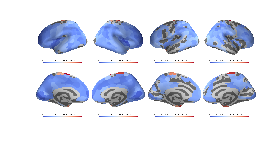

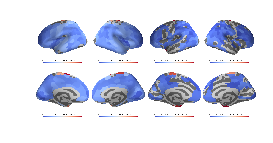

In [20]:
for my_str in ('_sex0_frwd', '_sex1_frwd'):
    # Age effects
    f, axes = plt.subplots(2, 4)
    f.set_figwidth(4)
    f.set_figheight(2)
    plt.subplots_adjust(wspace=0, hspace=0)


    # column 0:
    fig_str = 'lh_ct_age'+my_str+'.png'
    try:
#         axes[0,0].set_title('Thickness (L)', fontsize = 8)
        image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
    except FileNotFoundError: axes[0,0].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
    except FileNotFoundError: axes[1,0].axis('off')

    # column 1:
    fig_str = 'rh_ct_age'+my_str+'.png'
    try:
#         axes[0,1].set_title('Thickness (R)', fontsize = 8)
        image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
    except FileNotFoundError: axes[0,1].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
    except FileNotFoundError: axes[1,1].axis('off')

    # column 2:
    fig_str = 'lh_vol_age'+my_str+'.png'
    try:
#         axes[0,2].set_title('Jacobian (L)', fontsize = 8)
        image = mpimg.imread('lat_' + fig_str); axes[0,2].imshow(image); axes[0,2].axis('off')
    except FileNotFoundError: axes[0,2].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,2].imshow(image); axes[1,2].axis('off')
    except FileNotFoundError: axes[1,2].axis('off')

    # column 3:
    fig_str = 'rh_vol_age'+my_str+'.png'
    try:
#         axes[0,3].set_title('Jacobian (R)', fontsize = 8)
        image = mpimg.imread('lat_' + fig_str); axes[0,3].imshow(image); axes[0,3].axis('off')
    except FileNotFoundError: axes[0,3].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,3].imshow(image); axes[1,3].axis('off')
    except FileNotFoundError: axes[1,3].axis('off')

    plt.show()
    f.savefig('brain_age'+my_str+'.svg', dpi = 1200, bbox_inches = 'tight', pad_inches = 0)
    f.savefig('brain_age'+my_str+'.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)